# Imports

In [1]:
# Check if running in Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [ ]:
if is_colab:
    !pip install -r "https://raw.githubusercontent.com/AI-and-Security/old-soc-new-tricks/main/requirements-colab.txt"

In [ ]:

# Set up data directory based on environment
if is_colab:
    # Create data directory in Colab
    import os
    DATA_DIR = "./data"
    os.makedirs(DATA_DIR, exist_ok=True)
    
    # Download data files from GitHub repository
    !git clone https://github.com/AI-and-Security/old-soc-new-tricks.git temp_repo
    !mkdir -p {DATA_DIR}
    !cp -r temp_repo/data/* {DATA_DIR}/
    !rm -rf temp_repo
    print("✅ Data files downloaded to Colab environment")
else:
    # Local environment - use relative path
    DATA_DIR = "../data"

print(f"📂 Using data directory: {DATA_DIR}")

In [4]:
import time
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from itertools import combinations

# langchain imports
# from langchain.llms import Ollama, HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
#from langchain_google_vertexai import VertexAI

from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams, LLMTestCase


# traditional ML imports
from scipy.stats import ttest_ind, zscore
from summarytools import dfSummary

In [39]:
# # finds .env file and loads the vars
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "Key not found")
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "Key not found")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"

In [43]:
def create_openrouter_llm(model_name, temperature=0.7):
    return ChatOpenAI(
        model=model_name,
        openai_api_key=OPENROUTER_API_KEY,
        openai_api_base=OPENROUTER_BASE_URL,
        temperature=temperature
    )


In [44]:
models = {
    "Claude-Sonnet-4": create_openrouter_llm("anthropic/claude-sonnet-4"),
    "Gemini-2.5-Flash": create_openrouter_llm("google/gemini-2.5-flash"),
    "OpenAI-gpt-4o": create_openrouter_llm("openai/gpt-4o"),
}

# Initialization

In [9]:
READ_FROM_PICKLE = True

In [ ]:
if READ_FROM_PICKLE:
    malicious_df = pd.read_pickle("{DATA_DIR}/malicious_features_numeric.pkl")
    benign_df = pd.read_pickle("{DATA_DIR}/benign_features_numeric.pkl")

# EDA

## Statistical

In [22]:
def summarize_dataset(df):
    summary = f"""
    The dataset contains {len(df)} rows and it contains a network packet capture that was generated using Wireshark in an enterprize network.
    Study the first 100 rows of the dataset and try to understand what it describes:\n {df.head(100)}"
    Below are the summary statistics of the dataset\n {df.describe()}.
    """
    with open("../data/df_summary_mal.txt", "r") as f:
        summary += f"A summary that includes statistics, histograms is given below \n {f.read()}." 
    summary += "Identify any anomalies in this time series dataset. Justify your conclusions based on known detections and security attacks." 
    return summary

In [18]:
dfSummary(malicious_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Timestamp[float64],Mean (sd) : 1540450214.8 (2080.2)min < med < max:1540446382.9 < 1540450432.6 < 1540453519.8IQR (CV) : 3618.0 (740512.8),"154,090 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAjtJREFUeJzt3btu4kAYhuExOcgbECMOCxeQMh0SDReQMhebS0hBsTXFNlvRISHLCCdWjHFklEhpkPB4E/NN3qcNf4bihVHCLxEURWGAc9dq+gkAp7g86VHACYIg+GWMuTZuXouieDn2Q0L1TFAvlvKG3TvOhv1+/95a23YZ3mw2URAEj8diJVTPIh0MBg/dbrdXdTbP86skSW47nc6/VquVVZ3Psiw0xtxNp9M/w+FwU2U2juNwPp/31ut1+QIj1B/guox0Npu9WGvTKoPL5bK3WCx+TyaTv+PxOKp68Pv8TRiG2Wg0eq46b4wpb4KjCNWvq7u73++vrLVR1ViiKDqE0m63U5fQPua/CqF6cnV/XL95nt+lafpkjHF5VztbhOrJ1f35+t3tdhfGM4R6hspIz/H6bRL/8IcEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUfH6E2uIhbd17x7MP2k+OZPzfUJhdx68yrnu3z9tNXv6M2vYjrNK96ts/bT9+yPeWyzfO/FnFd5lXP9nn7qS7+mIIEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoU/3y4dx3FY9Rdvt9vDTJIk4Wq1uvnOedWzVZ+3qTl/Sl9vM49G1TR9R5EAAAAASUVORK5CYII="">",0(0.0%)
2,Source Port[float64],Mean (sd) : 31461.6 (18801.8)min < med < max:0.0 < 32761.0 < 65267.0IQR (CV) : 28964.0 (1.7),"22,952 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAn9JREFUeJzt3LuO2kAARuEZbvICAiEU6GhSRkrhkofIw+YRUvAEFGlS0SEhC4R3EcY4chEpScHaHl/4veerdzQjcbxrxuuxSZIY4Nl1ml4AkEUv008hF2vtizFmUHD4NUmSt5KXJI9QK4h0Pp9/m0wmsyLjT6dTYK39Tqz/ItTyDdJI1+v123Q6veQZeDwevc1mMzscDulvY0L9C6FWJI10sVi8Fhia3jbgP3yZggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRCRTv+cZr3f7TYln5eD0Pl/R8ttsWf13u/UXn/R8ugrZ9XpnemeP9Hy7SFnxdfpiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCEh02l+H/BA26c+1PYjamWorgfaNnmobRzHfWPMxFpbZPjkfr/3G5q70ou7laG6HGjb5KG2YRj2oyj6ulqtut1uN/e6oyjy4jj+crlcfhhjXuucu+qLu62huh5o28ihttfrted53tD3/ctyuQzyjt/tdrPtdju83W7duueu+uJudaiqRqNRoQssCIKXpuau+uLmWz8kECokECokcI+K0jhubz3c2iJUlMJ1e+u9rS1CRSlctreybG1VGmoJTzrSe+h73U9oHNfuPLeyUfHtrYdbW71n/VOQhhKG4efxePyr0+lEdT2hcV2769yoOdSSnrJ88n3/Z97xLk9oXNfuOjccQk3vIUxO5/M595iyhWHo7ff7YRNrLzL3n3ld1x2KzZ2lr9+Vq4p5CUmM+AAAAABJRU5ErkJggg=="">",0(0.0%)
3,Destination Port[float64],Mean (sd) : 6758.4 (7691.4)min < med < max:23.0 < 8280.0 < 65267.0IQR (CV) : 10187.0 (0.9),"3,691 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjUsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvWftoOwAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAkNJREFUeJzt2EGO2jAYhmG7ZBAzahNBpCy5QKUeIPtu57Cz7a6LnIAbsEFIESSCgU5IXHn2VYkDGj7mffZ2vHhlfmydcwa4dV8++gDAOSJzRdbaR2PMeMAWb865wwWPBFHRNSNN0/Q5juNp6B51XW+stS/EimveqGMfaZ7nhyRJjn0XV1U1KYpiWpalv5EJ9ZO76k+/5yPNsuw1cLkfHYD/hzpgzoy7rnsIOxbQI9Qhc2bTNJO2bb8fj8ffxpjQGxU460YNnjOXy+V0sVg8nU6nUZ91QPCMGjJnbjYb5ktcDA/+kECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokBCZO2WtfTTGjAds8eacO1zwSBggutdI0zR9juN4GrpHXdcba+0Lsd6GuwzV36Q+0jzPD0mSHPsurqpqUhTFtCxLfyMT6g2411Df+UizLHsNXO5HB9wI/kxBAqFCAqFCwl3PqEO0bftgjImttVJPW3bYs9zNPslF5/4L7rvxbrd7X7Pf7yfr9fqp73r/zbZto8BY4q7ropBze6vV6lvTND/m8/loNBr1fjXYbrc7a+0vY0zvtQNNZrPZzyRJvoYs/sBze3+cc//87l+vnZg3NCraiwAAAABJRU5ErkJggg=="">",0(0.0%)
4,Payload[object],1. Raw2. Padding3. 4. DNS Qry b'xmpp.samsungsmartcam5. DNS Ans name-error6. DNS Qry b'xmpp.samsungsmartcam7. DNS Qry b'10024backup.broadlin8. DNS Qry b'10024main.broadlink.9. DNS Qry b'www.baidu.com.'10. DNS Qry b'authentication.eye4.11. other,"64,946 (42.1%)28,136 (18.3%)22,577 (14.7%)7,099 (4.6%)4,561 (3.0%)3,550 (2.3%)2,216 (1.4%)

In [23]:
malicious_data_summary = summarize_dataset(malicious_df)
prompt_template = PromptTemplate(
    input_variables=["malicious_data_summary"],
    template="Analyze this dataset and identify anomalies and trends:\n{malicious_data_summary}",
)

In [24]:
malicious_data_summary

'\n    The dataset contains 154090 rows and it contains a network packet capture that was generated using Wireshark in an enterprize network.\n    Study the first 100 rows of the dataset and try to understand what it describes:\n         Timestamp  Source Port  Destination Port  \\\n0    1.540446e+09      21074.0              80.0   \n1    1.540446e+09      20532.0            8280.0   \n7    1.540446e+09       2440.0              53.0   \n8    1.540446e+09         53.0            2440.0   \n9    1.540446e+09      21074.0              80.0   \n..            ...          ...               ...   \n128  1.540446e+09      52259.0             443.0   \n130  1.540446e+09      47815.0              80.0   \n131  1.540446e+09      59225.0            8000.0   \n132  1.540446e+09      48977.0              80.0   \n133  1.540446e+09      50861.0           10240.0   \n\n                                               Payload  Packet Length  \\\n0                                              Padding  

In [45]:
statistical_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(
        prompt_template.format(malicious_data_summary=malicious_data_summary)
    )

    end_time = time.time()

    # Store results
    statistical_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Claude-Sonnet-4...

Claude-Sonnet-4 Response:
content='Based on my analysis of this network packet capture dataset, I\'ve identified several significant anomalies and trends that suggest malicious activity. Here\'s my comprehensive assessment:\n\n## Dataset Overview\nThis is a Wireshark capture from an enterprise network containing 154,090 packets collected over approximately 2 hours (timestamps from 1540446382 to 1540453519). The filename reference to "malicious_df" confirms this contains known malicious traffic.\n\n## Key Anomalies Identified\n\n### 1. **Suspicious DNS Activity**\n- **High volume of DNS queries**: 66.8% of traffic is UDP (protocol 17), predominantly DNS on port 53\n- **Specific suspicious domains**:\n  - `xmpp.samsungsmartcam.com` (7,099 queries - 4.6% of all packets)\n  - `10024backup.broadlink` and `10024main.broadlink` domains\n  - `authentication.eye4` domain\n- **DNS tunneling indicators**: The high frequency of specific domain queries sugg

### Hypothesis testing
- Is the difference between two groups or variables statistically significant?
- Use t-test to compare means of two groups
  - assumes that data follows normal distribution
- Types of variables
  - dependent: the effect of a phenomenon. For example, how does number of HTTP requests mean that a network is compromised?
  - independent: the cause. The number of HTTP requests affects whether a network is compromised.

In [46]:
malicious_df.pop("Payload")

0                                                   Padding
1                                                   Padding
7         DNS Qry b'xmpp.samsungsmartcam.com.Speedport_W...
8                                        DNS Ans name-error
9                                                   Padding
                                ...                        
764121                                                  Raw
764122                         DNS Qry b'time.windows.com.'
764124                                              Padding
764125                                              Padding
764136    DNS Qry b'north-america.pool.ntp.org.Speedport...
Name: Payload, Length: 154090, dtype: object

In [47]:
def hypothesis_testing(df, col1, col2):
    group1 = df[col1]
    group2 = df[col2]
    pvalue = ttest_ind(group1, group2)[1]
    if pvalue < 0.05:
        return "The difference between {} and {} is statistically significant (p < 0.05)".format(
            col1, col2
        )
    else:
        return "The difference between {} and {} is not statistically significant (p >= 0.05)".format(
            col1, col2
        )

In [48]:
def get_column_combinations(df):
    df_columns = df.columns.tolist()
    pairs = list(combinations(df_columns, 2))

    return pairs

In [49]:
def all_hypotheses(df):
    # perform hypothesis testing for all combinations of columns
    all_column_pairs = get_column_combinations(malicious_df)
    hypotheses = ""
    for pair in all_column_pairs:
        hypotheses += hypothesis_testing(df, pair[0], pair[1])
    # ask model to explain
    explain = f"""
    Below there is all the hypothesis testing performed with ttest for all the possible combinations of the features of the dataset. 
    Extract logical conclusions based on the hypotheses testings. 
    Is there a difference between two groups of variables that is statistically significant? 
    Can you conclude if there are dependent or independent variables in the dataset? \n ** Hypotheses Tests ** {hypotheses}
    """
    
    return explain 

In [50]:
hypotheses = all_hypotheses(malicious_df)
prompt_template = PromptTemplate(
    input_variables=["hypotheses"],
    template="Analyze this dataset based on the hypotheses tests and identify anomalies and trends:\n{hypotheses}",
)

In [51]:
hypotheses_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(prompt_template.format(hypotheses=hypotheses))

    end_time = time.time()

    # Store results
    hypotheses_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Claude-Sonnet-4...

Claude-Sonnet-4 Response:
content='Based on the comprehensive t-test analysis of this network traffic dataset, I can identify several key patterns, anomalies, and trends:\n\n## Key Findings\n\n### **Major Anomaly: Interarrival Variable Isolation**\nThe most striking anomaly is that **Interarrival** shows **no statistically significant differences** with any other variable in the dataset. This is highly unusual and suggests:\n- Interarrival may be independent of all network traffic characteristics\n- Possible data quality issues or measurement errors\n- The timing between packets might be following a completely different distribution or pattern\n\n### **Strong Network Traffic Dependencies**\nAll other variables show significant statistical relationships with each other, indicating a highly interconnected network system where:\n- Traffic patterns are not random\n- Network behaviors are interdependent\n- Changes in one parameter likely affect othe

In [52]:
hypotheses

'\n    Below there is all the hypothesis testing performed with ttest for all the possible combinations of the features of the dataset. \n    Extract logical conclusions based on the hypotheses testings. \n    Is there a difference between two groups of variables that is statistically significant? \n    Can you conclude if there are dependent or independent variables in the dataset? \n ** Hypotheses Tests ** The difference between Timestamp and Source Port is statistically significant (p < 0.05)The difference between Timestamp and Destination Port is statistically significant (p < 0.05)The difference between Timestamp and Packet Length is statistically significant (p < 0.05)The difference between Timestamp and Protocol is statistically significant (p < 0.05)The difference between Timestamp and src_ip_total_bytes is statistically significant (p < 0.05)The difference between Timestamp and dst_ip_total_bytes is statistically significant (p < 0.05)The difference between Timestamp and Numer

### Outliers
- observation that significantly differs from others in a dataset
- Causes
  - measurement errors
  - extreme rare values
- significant impact in statistical analysis
- measurements
  - z-score: `(x - mean) / std_dev`
  - IQR method: this method identifies outliers as observations that are below `Q1 - 1.5IQR` or above `Q3 + 1.5IQR`, where Q1 and Q3 are the first and third quartiles, and IQR is the interquartile range (the difference between Q3 and Q1).
  - visual inspection

In [53]:
def detect_outliers_zscore(df, column, threshold=3):
    zscores = np.abs(zscore(df[column]))
    return df[zscores > threshold]

In [54]:
def all_outliers(df):
    outliers = ""
    for feature in df.columns:
        outliers += f"Outlier scores for {feature} are {detect_outliers_zscore(df, feature, threshold=3)}"
        # ask model to explain
    explain = f"Below there is all the outliers scores calculated using zscore, for all the possible combinations of the features of the dataset. Extract logical conclusions based on the outliers. Do you find any interesting observations that stand out in the dataset based on the outlier calculations? What are your conclusions? \n ** Outlier Scores ** {outliers}"

    return explain

In [55]:
outliers = all_outliers(malicious_df)
prompt_template = PromptTemplate(
    input_variables=["outliers"],
    template="Analyze this dataset based on the outlier calculations and identify anomalies and trends:\n{outliers}",
)

In [56]:
outliers_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(prompt_template.format(outliers=outliers))

    end_time = time.time()

    # Store results
    outliers_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Claude-Sonnet-4...

Claude-Sonnet-4 Response:
content='Based on the outlier analysis of this network traffic dataset, I can identify several significant patterns and anomalies:\n\n## Key Findings\n\n### 1. **Destination Port Anomalies (2,211 outliers)**\n- **High-frequency unusual ports**: Multiple connections to uncommon destination ports like 32100, 41219, 41313\n- **Consistent source behavior**: Many outliers originate from source port 11570 targeting port 32100\n- **Protocol consistency**: Most anomalous destination port traffic uses UDP (Protocol 17)\n- **Potential concern**: This could indicate port scanning, tunneling, or malware communication\n\n### 2. **Packet Length Anomalies (1,542 outliers)**\n- **Oversized packets**: Packets of 145, 166 bytes are flagged as outliers\n- **Specific communication patterns**: \n  - Port 1900 traffic with 166-byte packets (likely UPnP/SSDP)\n  - Port 68 traffic with 166-byte packets (DHCP-related)\n- **High data volumes**:

In [57]:
outliers

'Below there is all the outliers scores calculated using zscore, for all the possible combinations of the features of the dataset. Extract logical conclusions based on the outliers. Do you find any interesting observations that stand out in the dataset based on the outlier calculations? What are your conclusions? \n ** Outlier Scores ** Outlier scores for Timestamp are Empty DataFrame\nColumns: [Timestamp, Source Port, Destination Port, Packet Length, Protocol, src_ip_total_bytes, dst_ip_total_bytes, Numeric Source IP, Numeric Destination IP, dst_port_freq_encoded, Interarrival]\nIndex: []Outlier scores for Source Port are Empty DataFrame\nColumns: [Timestamp, Source Port, Destination Port, Packet Length, Protocol, src_ip_total_bytes, dst_ip_total_bytes, Numeric Source IP, Numeric Destination IP, dst_port_freq_encoded, Interarrival]\nIndex: []Outlier scores for Destination Port are            Timestamp  Source Port  Destination Port  Packet Length  Protocol  \\\n342     1.540446e+09   

## Visualizations

In [58]:
eda_summary = summarize_dataset(malicious_df)    
prompt_template = PromptTemplate(
    input_variables=["eda_summary"],
    template=""" Given the following dataset summary statistics: 
    ### Summary statistics
    {eda_summary}
    Generate a Python script using Matplotlib and Seaborn to visualize:
    1. A time series plot of value over time,
    2. Highlight anomalies in the dataset,
    3. Suggest interesting trends
    """,
)

In [59]:
model_visualizations = {}
for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(prompt_template.format(eda_summary=eda_summary))

    end_time = time.time()

    # Store results
    model_visualizations[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Claude-Sonnet-4...

Claude-Sonnet-4 Response:
content='Based on the analysis of this network packet capture dataset, I can identify several anomalies and patterns that suggest potential security threats. Let me break down my findings and provide a comprehensive visualization script.\n\n## Anomaly Analysis\n\n### 1. **Protocol Distribution Anomaly**\n- Only 2 protocols present: TCP (6) at 33.2% and UDP (17) at 66.8%\n- This is unusual for enterprise networks which typically show more protocol diversity\n- High UDP traffic could indicate DNS tunneling or DDoS attacks\n\n### 2. **Port Usage Patterns**\n- Limited source IP diversity (only 22 distinct IPs) but high port variation (22,952 distinct source ports)\n- This suggests potential port scanning or botnet activity from a small set of compromised hosts\n\n### 3. **Payload Anomalies**\n- High frequency of "Raw" and "Padding" payloads (60.5% combined)\n- Excessive DNS queries for specific domains (Samsung, Broadlink,

# Compare datasets

In [60]:
benign_data_summary = summarize_dataset(benign_df)
prompt_template = PromptTemplate(
    input_variables=["malicious_data_summary", "benign_data_summary"],
    template="Analyze the two input datasets that were taken by a network tap using wireshark, based on the summaries given below: \n Dataset1 Summary: {malicious_data_summary}\n Dataset2 Summary: {benign_data_summary}.\n What are the differences, what are the similarities between the two datasets? Can you identify if any of the two datasets exhibits malicious or benign behavior? Why? Give any other interesting observations that you extract from the two datasets.",
)

In [61]:
comparison_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(
        prompt_template.format(
            malicious_data_summary=malicious_data_summary,
            benign_data_summary=benign_data_summary,
        )
    )

    end_time = time.time()

    # Store results
    comparison_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Claude-Sonnet-4...

Claude-Sonnet-4 Response:
content='Based on my analysis of these two network packet capture datasets, I can identify several key differences, similarities, and security implications:\n\n## Key Differences\n\n### Dataset Scale and Timespan\n- **Dataset 1**: 154,090 packets over ~2 hours (Oct 2018)\n- **Dataset 2**: 18,615 packets spanning ~10 years (2012-2022)\n\n### Traffic Characteristics\n- **Dataset 1**: Mixed protocol traffic (66.8% UDP, 33.2% TCP) with diverse payloads\n- **Dataset 2**: Predominantly UDP traffic with much larger packet sizes (mean 297 bytes vs 45 bytes)\n\n### Network Behavior Patterns\n- **Dataset 1**: Shows normal enterprise network activity with DNS queries, web traffic (ports 80, 443), and IoT device communications\n- **Dataset 2**: Exhibits highly suspicious patterns with extreme temporal distribution anomalies\n\n## Critical Security Anomalies in Dataset 2\n\n### 1. **Temporal Manipulation Indicators**\n- Packets spa

# Evaluate EDA with LLMs

In [62]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


In [63]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [64]:
# from cyberdata_mlai.classification import evaluate_model

correctness_metric = GEval(
    name="Correctness",
    criteria="Determine whether the actual output is factually correct based on the expected output.",
    # NOTE: you can only provide either criteria or evaluation_steps, and not both
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradicts any facts in 'expected output'",
        "You should give more points to the responses that are based on the logical analysis of numerical results.",
        "You should penalize responses that are lacking detailed explanations",
        "You should penalize responses that are contradictory to the ground truth",
        "Different numbers in the responses are OK, however contradicting opinions are not OK.",
    ],
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.EXPECTED_OUTPUT,
    ],
)

In [65]:
summary_human_output = """1. The source ports seem to have some unusually high frequencies in higher values and the destination ports exhibit high variability. This may indicate scanning.
2. The payload indicates dns queries to domains that resemble IoT devices such as broadlink routers.
3. The packet lengths show an interesting distribution of some unusually high values that may point to exfiltration or malware download. 
4. There is unusually high activity in UDP protocol that may be suspicious of unusual services.
5. There is also some unusual high frequency in destination port 23 and 2323 that point to telnet and IoT telnet.
6. Finally the interarrival is unusually short, and that may indicate Denial of Service attack."""

In [66]:
hypotheses_human_output = """ Based on the hypothesis testing results:
1. All pairs of variables seem unrelated to statistically significant differences.
2. Logically, variables that should correlate are the bytes in/out and interarrival but there seems not to be any correlation.
3. The results are inconclusive and additional analysis may be needed.
"""

In [67]:
outliers_human_output = """ Based on the outliers calculations we reach the following conclusions:
1. There are some destination port outliers that may indicate abnormal malicious behavior.
2. There are outliers in packet size that again may point to unusual activity.
"""

In [68]:
statistics_correctness = {} 
for llm_item in statistical_results.items():
    test_case = LLMTestCase(
        input=malicious_data_summary,
        actual_output=llm_item[1]["response"],
        expected_output=summary_human_output,
    )

    correctness_metric.measure(test_case)
    correctness_dict = {}

    print(f"Model {llm_item[0]} response correctness: {correctness_metric.score}")
    print(correctness_metric.reason)
    statistics_correctness[llm_item[0]] =  correctness_metric.score

/Users/preeti/preeti_gh/old-soc-new-tricks/.venv/lib/python3.10/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Claude-Sonnet-4 response correctness: 0.8562176500885798
The actual output aligns closely with the expected output, identifying anomalies such as high source port variability (scanning), suspicious DNS queries to IoT-related domains, high UDP activity, and short interarrival times (potential DoS). It also adds logical, numerically grounded analysis (e.g., specific percentages, byte counts, and port distributions) and provides detailed explanations for each anomaly. However, it omits explicit mention of high frequency on destination ports 23 and 2323 (telnet/IoT telnet), and does not directly discuss unusually high packet lengths as possible exfiltration or malware download, which are present in the expected output. Overall, the response is thorough, non-contradictory, and well-justified, but misses a couple of specific details.


Model Gemini-2.5-Flash response correctness: 0.825584547658684
The actual output aligns well with the expected output by identifying key anomalies such as high UDP activity, prevalence of small packets, DNS queries to IoT-related domains, and data quality issues (negative interarrival, zero source IP). It provides logical analysis of numerical results and justifies potential security implications like scanning, DoS, and IoT device risks. However, it misses explicit mention of high frequency in destination ports 23 and 2323 (telnet/IoT telnet) and does not discuss unusually high packet lengths that may indicate exfiltration or malware download, which are present in the expected output. The explanation is detailed and grounded in the data, but a few specific points are omitted.


Model OpenAI-gpt-4o response correctness: 0.767917868618784
The actual output aligns well with the expected output by identifying high-frequency UDP traffic, high variability in ports, and short interarrival times as potential indicators of scanning or DoS attacks. It also notes the prevalence of non-standard ports and suspicious payloads, which matches the expected focus on IoT-related DNS queries and possible exfiltration. However, it misses explicit mention of destination ports 23 and 2323 (telnet/IoT telnet) and does not directly discuss unusually high packet lengths as a sign of exfiltration or malware download. The response is detailed, logically analyzes numerical results, and avoids contradictions, but lacks a few specific details from the expected output.


In [69]:
hypothesis_correctness = {}
for llm_item in hypotheses_results.items():
    test_case = LLMTestCase(
        input=malicious_data_summary,
        actual_output=llm_item[1]["response"],
        expected_output=hypotheses_human_output,
    )

    correctness_metric.measure(test_case)
    print(f"Model {llm_item[0]} response correctness: {correctness_metric.score}")
    print(correctness_metric.reason)
    hypothesis_correctness[llm_item[0]]  = correctness_metric.score

Model Claude-Sonnet-4 response correctness: 0.3717869066122742
The actual output contradicts the expected output by claiming strong statistical dependencies among all variables except Interarrival, whereas the expected output states that all pairs of variables seem unrelated and that no significant correlations were found. The response does provide detailed explanations and logical analysis, but its conclusions about variable interdependence are not supported by the expected findings, which warrants a significant penalty. The output does well in discussing possible data quality issues and further investigation, but the core contradiction in statistical relationships reduces alignment with the evaluation steps.


Model Gemini-2.5-Flash response correctness: 0.39619527991592557
The response provides a detailed explanation of statistical significance and dependencies, but it contradicts the expected output by claiming that almost all variable pairs show statistically significant differences, whereas the expected output states that all pairs seem unrelated to statistically significant differences. The response does use logical analysis and discusses numerical results, but it fails to align with the ground truth and does not identify the lack of correlation as expected. The explanation is thorough, but the contradiction in interpretation warrants a significant penalty.


Model OpenAI-gpt-4o response correctness: 0.37489265144741446
The actual output provides a detailed explanation of variable relationships and statistical significance, but it contradicts the expected output by claiming there are statistically significant differences between most variable pairs, while the expected output states that all pairs seem unrelated and the results are inconclusive. The response is logically structured and numerically grounded, but it fails to align with the ground truth and overstates the findings, warranting a moderate penalty.


In [70]:
outlier_correctness = {}
for llm_item in outliers_results.items():
    test_case = LLMTestCase(
        input=malicious_data_summary,
        actual_output=llm_item[1]["response"],
        expected_output=outliers_human_output,
    )

    correctness_metric.measure(test_case)
    print(f"Model {llm_item[0]} response correctness: {correctness_metric.score}")
    print(correctness_metric.reason)
    outlier_correctness[llm_item[0]] = correctness_metric.score

Model Claude-Sonnet-4 response correctness: 0.8679178699175394
The actual output aligns well with the expected output by identifying destination port and packet size anomalies as potential indicators of malicious activity, which matches the core findings in the expected output. It goes further by providing detailed, logical analysis of numerical results (e.g., specific ports, packet sizes, byte volumes, and counts of outliers), and connects these to known security threats such as IP spoofing, port scanning, and data exfiltration. The explanation is thorough and well-justified, referencing concrete statistics and attack types. The only minor shortcoming is that it introduces additional anomaly types (e.g., source IP zero, byte volume outliers) not explicitly mentioned in the expected output, but these do not contradict the ground truth and are logically derived from the data. The response is detailed and not contradictory, thus only a slight deduction for exceeding the expected scope.


Model Gemini-2.5-Flash response correctness: 0.888079707015525
The actual output aligns well with the expected output and evaluation steps. It does not contradict the expected output and provides a detailed, logical analysis of the numerical outlier results, specifically highlighting destination port and packet length anomalies as potential indicators of abnormal or malicious behavior. The response goes further by contextualizing these outliers (e.g., DHCP, DNS, custom ports), distinguishing between expected and unexpected anomalies, and offering security-relevant interpretations. The explanation is thorough and well-justified, though it is more verbose than necessary, which is a minor shortcoming. Overall, it demonstrates strong alignment with the evaluation criteria.


Model OpenAI-gpt-4o response correctness: 0.7911382525202313
The actual output aligns well with the expected output by identifying outliers in destination port and packet length as potential indicators of malicious or abnormal activity, which matches the expected conclusions. The response also provides additional logical analysis by discussing outliers in dst_ip_total_bytes and Numeric Source IP, and connects these to possible security concerns, which adds value. However, the explanation is somewhat verbose and introduces extra details (e.g., z-score method, specific outlier counts, and other features) that are not directly referenced in the expected output, making it slightly less focused. There are no contradictions or unsupported claims, and the reasoning is grounded in numerical analysis, but a more concise focus on the key expected findings would improve alignment.


In [71]:
all_scores = []
for model_name, score in statistics_correctness.items():
    score_dict = {}
    score_dict[model_name] = {
        "statistics_correctness": score,
        "hypothesis_correctness": hypothesis_correctness[model_name],
        "outlier_correctness": outlier_correctness[model_name],
    }
    all_scores.append(score_dict)

all_scores

[{'Claude-Sonnet-4': {'statistics_correctness': 0.8562176500885798,
   'hypothesis_correctness': 0.3717869066122742,
   'outlier_correctness': 0.8679178699175394}},
 {'Gemini-2.5-Flash': {'statistics_correctness': 0.825584547658684,
   'hypothesis_correctness': 0.39619527991592557,
   'outlier_correctness': 0.888079707015525}},
 {'OpenAI-gpt-4o': {'statistics_correctness': 0.767917868618784,
   'hypothesis_correctness': 0.37489265144741446,
   'outlier_correctness': 0.7911382525202313}}]

In [ ]:
# Convert to long-format DataFrame
all_scores_df_long = pd.DataFrame(
    [
        {"Model": list(item.keys())[0], "Metric": metric, "Score": value}
        for item in all_scores
        for metric, value in list(item.values())[0].items()
    ]
)
all_scores_df_long.to_csv("../data/all_scores_eda.csv", index=False)
all_scores_df_long

,Model,Metric,Score
0,Claude-Sonnet-4,statistics_correctness,0.856218
1,Claude-Sonnet-4,hypothesis_correctness,0.371787
2,Claude-Sonnet-4,outlier_correctness,0.867918
3,Gemini-2.5-Flash,statistics_correctness,0.825585
4,Gemini-2.5-Flash,hypothesis_correctness,0.396195
5,Gemini-2.5-Flash,outlier_correctness,0.888080
6,OpenAI-gpt-4o,statistics_correctness,0.767918
7,OpenAI-gpt-4o,hypothesis_correctness,0.374893
8,OpenAI-gpt-4o,outlier_correctness,0.791138


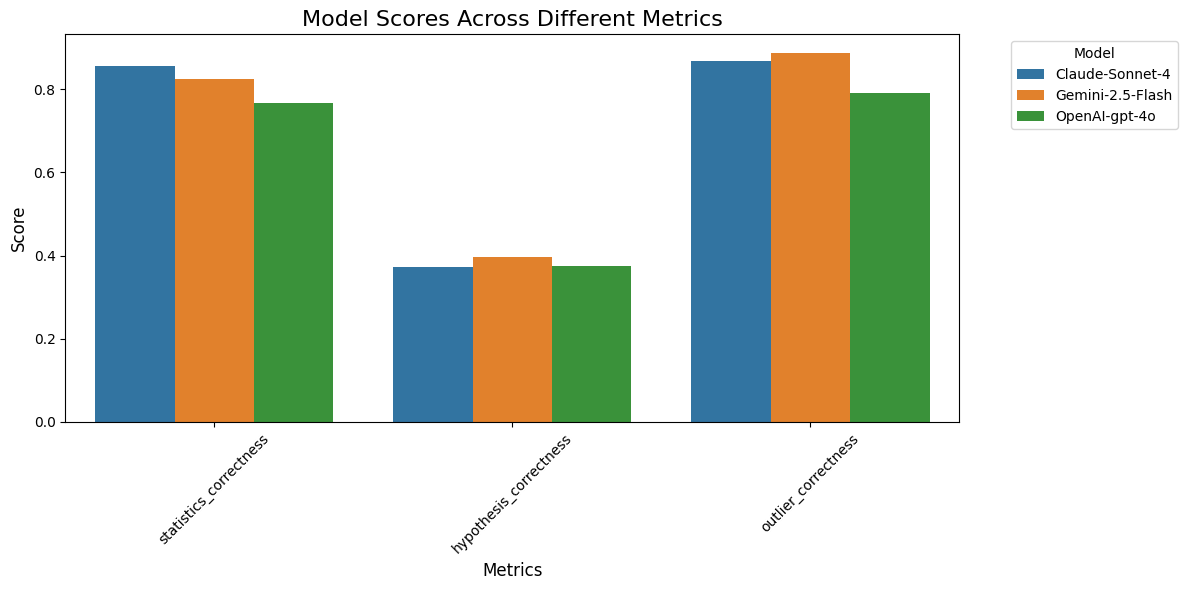

In [73]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=all_scores_df_long)

# Customize the plot
plt.title("Model Scores Across Different Metrics", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()